# HW2 Kaggle Competition: Stroke Prediction: End-to-End ML Pipeline

## Data loading and cleaning

In [1]:
import pandas as pd
train_df = pd.read_csv("/Users/kaylenamann/Downloads/BC Grad/2025Fall_ADAN7430/assignments/HW2/RawData/train.csv")
print(train_df.head())
print(train_df.info()) 

# importing variables of choice
import statsmodels.api as sm
feature_cols = ['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type','avg_glucose_level', 'bmi', 'smoking_status']
X = pd.get_dummies(train_df[feature_cols], drop_first=True)
y = train_df['stroke']
X = sm.add_constant(X, has_constant='add')
X = X.astype(float)

   id  gender   age  hypertension  heart_disease ever_married work_type  \
0   1    Male  50.0             0              0          Yes   Private   
1   2  Female  52.0             0              0          Yes   Private   
2   3  Female  26.0             0              0           No  Govt_job   
3   4  Female  37.0             0              0          Yes   Private   
4   5    Male  59.0             0              0          Yes   Private   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Rural              88.10  29.1  formerly smoked       0  
1          Rural              80.07  38.9           smokes       0  
2          Urban              89.11  23.3           smokes       0  
3          Rural              81.36  36.1     never smoked       0  
4          Rural              82.59  29.6     never smoked       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12243 entries, 0 to 12242
Data columns (total 12 columns):
 #   Column             No

Data looks good, with no missing values or unexpected results

## Exploratory analysis 

### Checking the balance of our outcome

In [2]:
stroke_counts = train_df['stroke'].value_counts()
print("Frequency Counts:")
print(stroke_counts)

Frequency Counts:
stroke
0    11737
1      506
Name: count, dtype: int64


Our outcome is severely unbalanced, with far more non-strokes (0) than strokes (1), we should be mindful of this when tuning parameters and deciding on our model.

### Correlations

In [3]:
corr_df = train_df[['avg_glucose_level', 'bmi', 'age', 'gender', 'hypertension', 'heart_disease', 'Residence_type', 'smoking_status']].copy()

from sklearn.preprocessing import LabelEncoder

le_gender = LabelEncoder()
le_residence = LabelEncoder()
le_smoking = LabelEncoder()

corr_df['gender'] = le_gender.fit_transform(corr_df['gender'])
corr_df['Residence_type'] = le_residence.fit_transform(corr_df['Residence_type'])
corr_df['smoking_status'] = le_smoking.fit_transform(corr_df['smoking_status'])

corr = corr_df.corr()
print(corr)

                   avg_glucose_level       bmi       age    gender  \
avg_glucose_level           1.000000  0.102402  0.104781  0.036219   
bmi                         0.102402  1.000000  0.394478 -0.014654   
age                         0.104781  0.394478  1.000000 -0.033510   
gender                      0.036219 -0.014654 -0.033510  1.000000   
hypertension                0.127983  0.109486  0.230497  0.013709   
heart_disease               0.126950  0.058888  0.194991  0.060208   
Residence_type             -0.016779  0.009969  0.015401 -0.000153   
smoking_status              0.025856  0.262331  0.287528 -0.075070   

                   hypertension  heart_disease  Residence_type  smoking_status  
avg_glucose_level      0.127983       0.126950       -0.016779        0.025856  
bmi                    0.109486       0.058888        0.009969        0.262331  
age                    0.230497       0.194991        0.015401        0.287528  
gender                 0.013709       0.06020

Prior research has shown that smoking status is related to stroke indicators (Gan et al., 2018; Zhou et al., 2008), and can often interact. These correlations above add evidence to support this, with smoking having a moderate relationship with age and BMI. Additionally, BMI and age have a moderate relationship, so these interactions will be added to the model.

### Centering metric features and creating interactions 

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

# doing a train/test split (ON THE TRAINING DATA ONLY)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=39, stratify=y)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

###  Running Diagnostic checks for non-linearity - Box-Tidwell

sm.GLM was used here to conduct the Box-Tidwell test in order to see the actual coefficients and p-values. None of the log-transformed interaction terms were significant (*p* > .05), indicating that the assumption of linearity in the logit was likely met.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

continuous_vars = ['age', 'avg_glucose_level', 'bmi']

# Running an original model without the log variables
model_original = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results_original = model_original.fit()
print(results_original.summary())

# Creating log interaction versions of the original variables
X_train_bt = X_train.copy()
for var in continuous_vars:
    X_train_bt[f'{var}_logint'] = X_train_bt[var] * np.log(X_train_bt[var] + 1)
    
model_bt = sm.GLM(y_train, X_train_bt, family=sm.families.Binomial())
results_bt = model_bt.fit()

# Comparing AIC and BIC between models
print("Original AIC:", results_original.aic)
print("Box–Tidwell AIC:", results_bt.aic)
print("\nBox–Tidwell model summary:")
print(results_bt.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 stroke   No. Observations:                 8570
Model:                            GLM   Df Residuals:                     8558
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1088.2
Date:                Fri, 17 Oct 2025   Deviance:                       2176.4
Time:                        16:24:55   Pearson chi2:                 6.33e+03
No. Iterations:                    19   Pseudo R-squ. (CS):            0.08625
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

## Feature Engineering
LogisticRegression for sklearn was used for the actual parameter tuning, since we can more easily add weights to account for imbalanced outcome. 

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import get_scorer_names
from sklearn.preprocessing import StandardScaler

# Centering metric variables
for col in ["age", "bmi", "avg_glucose_level"]:
    mean_c = X_train[col].mean()
    X_train[f"{col}_c"] = X_train[col] - mean_c
    X_test[f"{col}_c"] = X_test[col] - mean_c

In [7]:
# Dropping the constant because LogisticRegression code does not need it
X_train_for_sklearn = X_train.drop(columns=['const', 'age', 'bmi', 'avg_glucose_level'])
X_test_for_sklearn = X_test.drop(columns=['const', 'age', 'bmi', 'avg_glucose_level'])

# Adding in interaction terms to our model
X_train_for_sklearn["age_bmi_int"] = X_train_for_sklearn["age_c"] * X_train_for_sklearn["bmi_c"]
X_test_for_sklearn["age_bmi_int"] = X_test_for_sklearn["age_c"] * X_test_for_sklearn["bmi_c"]

for col in X_train_for_sklearn.columns:
    if 'smoking_status' in col:  
        X_train_for_sklearn[f'age_{col}_int'] = X_train_for_sklearn['age_c'] * X_train_for_sklearn[col]
        X_train_for_sklearn[f'bmi_{col}_int'] = X_train_for_sklearn['bmi_c'] * X_train_for_sklearn[col]
        X_test_for_sklearn[f'age_{col}_int'] = X_test_for_sklearn['age_c'] * X_test_for_sklearn[col]
        X_test_for_sklearn[f'bmi_{col}_int'] = X_test_for_sklearn['bmi_c'] * X_test_for_sklearn[col]

In [8]:
# Testing different thresholds for our logistic regression
cols_to_scale = [c for c in ["age_c", "bmi_c", "age_bmi_int", "avg_glucose_level_c"]
                 if c in X_train_for_sklearn.columns]

scaler = StandardScaler()
X_train_for_sklearn[cols_to_scale] = scaler.fit_transform(X_train_for_sklearn[cols_to_scale])
X_test_for_sklearn[cols_to_scale]  = scaler.transform(X_test_for_sklearn[cols_to_scale])

scorer = make_scorer(f1_score, pos_label=1)
base_model = LogisticRegression(max_iter=2000, class_weight="balanced")
model = TunedThresholdClassifierCV(base_model, scoring=scorer, cv=5)
model.fit(X_train_for_sklearn, y_train)

#Double-checking that no variables were written-over
print(X_test_for_sklearn.isnull().sum())
print(np.isinf(X_test_for_sklearn).sum())
print(X_test_for_sklearn.columns)
print(X_train_for_sklearn.columns)

hypertension                              0
heart_disease                             0
gender_Male                               0
gender_Other                              0
Residence_type_Urban                      0
smoking_status_formerly smoked            0
smoking_status_never smoked               0
smoking_status_smokes                     0
age_c                                     0
bmi_c                                     0
avg_glucose_level_c                       0
age_bmi_int                               0
age_smoking_status_formerly smoked_int    0
bmi_smoking_status_formerly smoked_int    0
age_smoking_status_never smoked_int       0
bmi_smoking_status_never smoked_int       0
age_smoking_status_smokes_int             0
bmi_smoking_status_smokes_int             0
dtype: int64
hypertension                              0
heart_disease                             0
gender_Male                               0
gender_Other                              0
Residence_type_Urba

In [39]:
print(model.best_threshold_)
print(model.best_score_)
print("Training features:", X_train_for_sklearn.shape)
print("Test features:", X_test_for_sklearn.shape)
print("Training columns:", X_train_for_sklearn.columns.tolist())
print("Test columns:", X_test_for_sklearn.columns.tolist())
print("Any NaN/Inf?", X_train_for_sklearn.isnull().sum().sum(), np.isinf(X_train.values).sum())

Processed_TrainingData = X_train_for_sklearn.copy()
Processed_TrainingData['stroke'] = y_train
Processed_TrainingData.to_csv(
    '/Users/kaylenamann/Downloads/BC Grad/2025Fall_ADAN7430/assignments/HW2/ProcessedData/Processed_TrainingData.csv', 
    index=False
)
print("\nProcessed training data saved successfully.")


Processed_TestData = X_test_for_sklearn.copy()
Processed_TestData['stroke'] = y_test
Processed_TestData.to_csv(
    '/Users/kaylenamann/Downloads/BC Grad/2025Fall_ADAN7430/assignments/HW2/ProcessedData/Processed_TestData.csv', 
    index=False
)
print("\nProcessed test data saved successfully.")

0.12121212121212122
0.2851379862601008
Training features: (8570, 18)
Test features: (3673, 18)
Training columns: ['hypertension', 'heart_disease', 'gender_Male', 'gender_Other', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'age_c', 'bmi_c', 'avg_glucose_level_c', 'age_bmi_int', 'age_smoking_status_formerly smoked_int', 'bmi_smoking_status_formerly smoked_int', 'age_smoking_status_never smoked_int', 'bmi_smoking_status_never smoked_int', 'age_smoking_status_smokes_int', 'bmi_smoking_status_smokes_int']
Test columns: ['hypertension', 'heart_disease', 'gender_Male', 'gender_Other', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'age_c', 'bmi_c', 'avg_glucose_level_c', 'age_bmi_int', 'age_smoking_status_formerly smoked_int', 'bmi_smoking_status_formerly smoked_int', 'age_smoking_status_never smoked_int', 'bmi_smoking_status_never smoked_int', 'age_smoking_

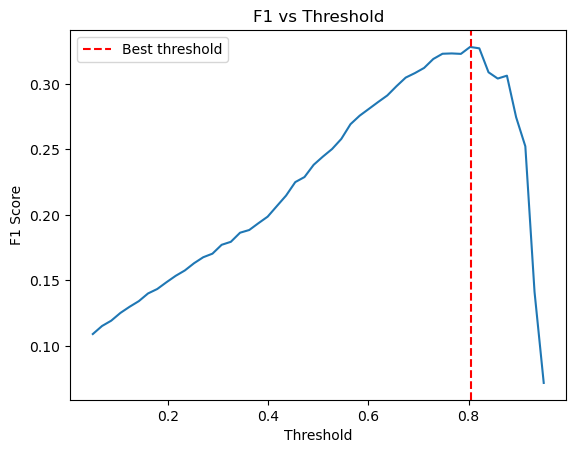

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

#Visually plotting our threshold values against F1-scores

probs = model.estimator_.predict_proba(X_test_for_sklearn)[:, 1]
thresholds = np.linspace(0.05, 0.95, 50)
f1s = [f1_score(y_test, (probs >= t).astype(int)) for t in thresholds]

plt.plot(thresholds, f1s)
plt.axvline(model.best_threshold_, color='red', linestyle='--', label='Best threshold')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 vs Threshold")
plt.legend()
plt.show()

## Model Selection on the holdout test set

Now we will generate predictions on our holdout validation set **(remember this is held out from the training set, not the actual competition test set)** using different models. 

### Binary Logistic Regression

In [11]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, recall_score, precision_score,
    precision_recall_curve, auc
)

y_pred_logistic = model.predict(X_test_for_sklearn)

### KNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer

f1_results = {}

#Testing different kneighbors
for k in [5, 7, 9, 11, 15, 17, 21, 23, 25]:
    base_model = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    model = TunedThresholdClassifierCV(base_model, scoring=scorer, cv=5)
    model.fit(X_train_for_sklearn, y_train)
    y_pred = model.predict(X_test_for_sklearn)
    f1 = f1_score(y_test, y_pred)
    print(f"KNN k={k}: F1 = {f1:.4f}, Threshold = {model.best_threshold_:.3f}")

KNN k=5: F1 = 0.2412, Threshold = 0.008
KNN k=7: F1 = 0.2239, Threshold = 0.007
KNN k=9: F1 = 0.2765, Threshold = 0.114
KNN k=11: F1 = 0.2667, Threshold = 0.180
KNN k=15: F1 = 0.2523, Threshold = 0.139
KNN k=17: F1 = 0.2737, Threshold = 0.125
KNN k=21: F1 = 0.3100, Threshold = 0.150
KNN k=23: F1 = 0.3052, Threshold = 0.132
KNN k=25: F1 = 0.3067, Threshold = 0.121


### Binary Logistic Regularization (L2) model

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, precision_recall_curve, auc

logistic_l2 = LogisticRegression(penalty='l2', C=0.1, solver='liblinear', 
                                  class_weight='balanced', random_state=39)
logistic_l2.fit(X_train_for_sklearn, y_train)  

y_pred_l2 = logistic_l2.predict(X_test_for_sklearn)

## Model evaluation and comparison

Finally, we compare evaluation metrics such as the confusion matrix and classifcation report along with Accuracy and ROC curve. We focus mainly of the F1-score and the precision recall curve since we have an imbalanced outcome. 

### Regular Logistic Regression Results

In [16]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logistic))
print("Classification Report:\n", classification_report(y_test, y_pred_logistic, digits=3))
print("Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("ROC AUC:", roc_auc_score(y_test, probs))

prec, rec, thr = precision_recall_curve(y_test, probs)
pr_auc = auc(rec, prec)
print("PR-AUC:", pr_auc)

Confusion Matrix:
 [[3247  274]
 [  68   84]]
Classification Report:
               precision    recall  f1-score   support

           0      0.979     0.922     0.950      3521
           1      0.235     0.553     0.329       152

    accuracy                          0.907      3673
   macro avg      0.607     0.737     0.640      3673
weighted avg      0.949     0.907     0.924      3673

Accuracy: 0.906888102368636
ROC AUC: 0.8823207372307509
PR-AUC: 0.2524421702156852


### KNN Results

In [17]:
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=21))
])
final_model = TunedThresholdClassifierCV(best_model, scoring=scorer, cv=5)
final_model.fit(X_train_for_sklearn, y_train)

y_pred_knn = final_model.predict(X_test_for_sklearn)
probs_knn  = final_model.estimator_.predict_proba(X_test_for_sklearn)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn, digits=3))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("ROC AUC:", roc_auc_score(y_test, probs_knn))

prec, rec, thr = precision_recall_curve(y_test, probs_knn)
pr_auc = auc(rec, prec)
print("PR-AUC:", pr_auc)

Confusion Matrix:
 [[3335  186]
 [  90   62]]
Classification Report:
               precision    recall  f1-score   support

           0      0.974     0.947     0.960      3521
           1      0.250     0.408     0.310       152

    accuracy                          0.925      3673
   macro avg      0.612     0.678     0.635      3673
weighted avg      0.944     0.925     0.933      3673

Accuracy: 0.9248570650694256
ROC AUC: 0.8122001076249272
PR-AUC: 0.2031342560989437


### L2 Regularization Results

In [18]:
probs = logistic_l2.predict_proba(X_test_for_sklearn)[:, 1]

accuracy_l2 = accuracy_score(y_test, y_pred_l2)
print(f"Accuracy with L2 regularization: {accuracy_l2:.2f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_l2))
print("Classification Report:\n", classification_report(y_test, y_pred_l2, digits=3))
print("ROC AUC:", roc_auc_score(y_test, probs))

prec, rec, thr = precision_recall_curve(y_test, probs)
pr_auc = auc(rec, prec)
print("PR-AUC:", pr_auc)

Accuracy with L2 regularization: 0.78
Confusion Matrix:
 [[2733  788]
 [  23  129]]
Classification Report:
               precision    recall  f1-score   support

           0      0.992     0.776     0.871      3521
           1      0.141     0.849     0.241       152

    accuracy                          0.779      3673
   macro avg      0.566     0.812     0.556      3673
weighted avg      0.956     0.779     0.845      3673

ROC AUC: 0.8817844810834243
PR-AUC: 0.2490957985846403


## Using our final model on the test set

In [28]:
test_df = pd.read_csv("/Users/kaylenamann/Downloads/BC Grad/2025Fall_ADAN7430/assignments/HW2/RawData/test.csv")

print("Test data shape:", test_df.shape)
print(test_df.head())

Test data shape: (3061, 11)
   id  gender   age  hypertension  heart_disease ever_married work_type  \
0   1  Female  40.0             0              0          Yes   Private   
1   2  Female  31.0             0              0          Yes   Private   
2   3    Male  50.0             0              0          Yes   Private   
3   4  Female  34.0             0              0          Yes   Private   
4   5  Female  52.0             0              0          Yes  Govt_job   

  Residence_type  avg_glucose_level   bmi   smoking_status  
0          Urban              94.65  34.7     never smoked  
1          Urban              97.24  29.0          Unknown  
2          Rural              95.52  31.4           smokes  
3          Urban              80.03  19.8  formerly smoked  
4          Rural             206.59  39.4  formerly smoked  


In [29]:
feature_cols = ['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
X_test_kaggle = test_df[feature_cols].copy()

X_test_kaggle = pd.get_dummies(X_test_kaggle, drop_first=True)
X_test_kaggle = X_test_kaggle.astype(float)
X_test_kaggle = X_test_kaggle.reindex(columns=X_train.columns, fill_value=0)

In [30]:
#repeating the same process
for col in ["age", "bmi", "avg_glucose_level"]:
    mean_c = X_train[col].mean() 
    X_test_kaggle[f"{col}_c"] = X_test_kaggle[col] - mean_c

X_test_kaggle["age_bmi_int"] = X_test_kaggle["age_c"] * X_test_kaggle["bmi_c"]

for col in X_test_kaggle.columns:
    if 'smoking_status_' in col:
        X_test_kaggle[f'age_{col}_int'] = X_test_kaggle['age_c'] * X_test_kaggle[col]
        X_test_kaggle[f'bmi_{col}_int'] = X_test_kaggle['bmi_c'] * X_test_kaggle[col]

X_test_kaggle = X_test_kaggle.drop(columns=['const','age', 'bmi', 'avg_glucose_level'])

In [31]:
cols_to_scale = [c for c in ["age_c", "bmi_c", "age_bmi_int", "avg_glucose_level_c"]
                 if c in X_test_kaggle.columns]

X_test_kaggle[cols_to_scale] = scaler.transform(X_test_kaggle[cols_to_scale])

#Checking that our test columns match our training columns
print("Test features shape:", X_test_kaggle.shape)
print("Test columns:", X_test_kaggle.columns.tolist())

Test features shape: (3061, 18)
Test columns: ['hypertension', 'heart_disease', 'gender_Male', 'gender_Other', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'age_c', 'bmi_c', 'avg_glucose_level_c', 'age_bmi_int', 'age_smoking_status_formerly smoked_int', 'bmi_smoking_status_formerly smoked_int', 'age_smoking_status_never smoked_int', 'bmi_smoking_status_never smoked_int', 'age_smoking_status_smokes_int', 'bmi_smoking_status_smokes_int']


In [32]:
y_pred_final = model.predict(X_test_kaggle)

#making sure our shape is correct and the number of predictions
print("Predictions shape:", y_pred_final.shape)
print("Number of predicted strokes:", (y_pred_final == 1).sum())
print("Number of predicted no strokes:", (y_pred_final == 0).sum())

Predictions shape: (3061,)
Number of predicted strokes: 274
Number of predicted no strokes: 2787


In [37]:
#creating the final csv file for submission
submission = pd.DataFrame({
    'id': test_df['id'],
    'stroke': y_pred_final
})

print("\nSubmission preview:")
print(submission.head(10))
print(f"\nSubmission shape: {submission.shape}")
print(f"Submission columns: {submission.columns.tolist()}")

submission.to_csv('/Users/kaylenamann/Downloads/BC Grad/2025Fall_ADAN7430/assignments/HW2/Output/Submission.csv', index=False)
print("\nSubmission saved to Output/submission.csv")


Submission preview:
   id  stroke
0   1       0
1   2       0
2   3       0
3   4       0
4   5       1
5   6       0
6   7       0
7   8       0
8   9       0
9  10       0

Submission shape: (3061, 2)
Submission columns: ['id', 'stroke']

Submission saved to Output/submission.csv


## Conclusion

| Model | F1   | PR-AUC |
|------:|:----:|-------:|
| LogReg| 0.33 | 0.25   |
| KNN   | 0.31 | 0.20   |
| L2Reg | 0.24 | 0.25   |

### The features and outcome were first evaluated descriptively to check for imbalance, non-linearity, and potential interactions.

- The outcome was heavily imbalanced with very few cases of stroke (1).
- There were a few moderate correlations between variables, indicating potential for interactions (in line with research).
    - BMI and Age
    - Age and smoking status
    - BMI and smoking status
- No evidence of non-linearity with the logit for the continuous variables, so no polynomial terms were added.

### Different models were tested with the goal of maximizing the F1-score to catch more cases of stroke

- Logistic regression with class weights added and tuned threshold
    - F1-Score: .33
- KNN with class weights added and tuned threshold
    - F1-Score: .32
- L2 regularization with class weights
    - F1-Score: .24

### **Overall, the normal logistic regression performed the best on the holdout set with an F1-score of .33, when submitted to the Kaggle competition, our final score was .28**

References: 

Gan, Y., Wu, J., Li, L., Zhang, S., Yang, T., Tan, S., Mkandawire, N., Zhong, Y., Jiang, J., Wang,Z., & Lu, Z. (2018). Association of smoking with risk of stroke in middle-aged and older Chinese: Evidence from the China National Stroke Prevention Project. *Medicine, 97*(47), e13260. https://doi.org/10.1097/MD.0000000000013260

Zhou, L., Chen, G., Liu, C., Liu, L., Zhang, S., & Zhao, X. (2008). Body mass index, blood pressure, and mortality from stroke: a prospective cohort study. *Stroke, 39*(7), 2065–2071. https://doi.org/10.1161/STROKEAHA.107.495374